In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for KAN Model
import kan
from sklearn.model_selection import TimeSeriesSplit
import torch

#Network Analysis and Clustering
from scipy.spatial import distance
import networkx as nx

#Stationarity Testing
import statsmodels as sm

#GLASSO
from sklearn import covariance, preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Dcov
import dcor

#Progress bar
import sys
def drawProgressBar(percent, barLen = 20):
    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
    sys.stdout.flush()

In [14]:
NetworkDf = pd.read_csv('../NetworkDataSets/CellCounts2015_2020.csv').drop(['Unnamed: 0', 'Observation Date'], axis = 1)

NetworkDf[NetworkDf.select_dtypes(include=['number', 'object']).columns] = NetworkDf.select_dtypes(include=['number', 'object']).astype(float)



In [15]:
NetworkDf = NetworkDf.groupby(['Cell', "TimeStamp"]).size().reset_index(name='n').pivot(index = 'TimeStamp', columns = "Cell", values = "n").fillna(value = 0)

NetworkDf.head()

Cell,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,552.0,553.0,554.0,555.0,556.0,557.0,558.0,559.0,560.0,561.0
TimeStamp,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,1.0,1.0,4.0,1.0,11.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,2.0,0.0,15.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,6.0,7.0,2.0,15.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Seasonality fixing!!!
res = sm.tsa.seasonal.seasonal_decompose(NetworkDf)

In [17]:
ProportionDf = NetworkDf
ProportionDf['Sum'] = ProportionDf.apply(np.sum, axis = 1)
ProportionDf = ProportionDf.apply(lambda o: o / o.Sum, axis = 1)
ProportionDf = ProportionDf.drop("Sum", axis = 1)

Corr_Matrix = NetworkDf.corr()
Proportion_Corr_Matrix = ProportionDf.corr()
Proportion_Cov_Matrix = ProportionDf.cov()
RollingDf = ProportionDf.rolling(3).sum().dropna()


Cell,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,552.0,553.0,554.0,555.0,556.0,557.0,558.0,559.0,560.0,561.0
TimeStamp,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.00000,0.001238,0.001238,0.004950,0.001238,0.013614,0.006188,0.000000,0.003713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.00000,0.002146,0.000000,0.000000,0.002146,0.025751,0.004292,0.000000,0.002146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.00000,0.000000,0.000000,0.003279,0.000000,0.024590,0.006557,0.001639,0.008197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.00000,0.000000,0.013043,0.015217,0.004348,0.032609,0.002174,0.000000,0.006522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.00303,0.006061,0.000000,0.003030,0.003030,0.012121,0.006061,0.018182,0.003030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X = RollingDf.iloc[:-1,:]
Y = RollingDf.iloc[1:, :]
tss = TimeSeriesSplit(n_splits = 5)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    Y_train, Y_test = Y.iloc[train_index, :], Y.iloc[test_index, :]
print(X_train.shape)
print(Y_train.shape)

(1315, 788)
(1315, 788)


In [7]:
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train.to_numpy())
dataset['train_label'] = torch.from_numpy(Y_train.to_numpy())
dataset['test_input'] = torch.from_numpy(X_test.to_numpy())
dataset['test_label'] = torch.from_numpy(Y_test.to_numpy())

In [ ]:

#Run when I gts
KANModel = kan.KAN(width = [NetworkDf.shape[1]-1, 5, NetworkDf.shape[1]-1], grid = 3, k=3, seed = 0)
history = KANModel.train(dataset, steps=20)

plt.plot(history['train_loss'], color = "green")
plt.plot(history['test_loss'], color = 'red')

KANModel.save_ckpt('KAN_20Steps.ckpt')

In [17]:
#Distance Correlation Edges and Eigvenvectors
def Distance_Correlation(M):
    final = np.zeros((M.shape[1], M.shape[1]))
    for row_index, i in enumerate(np.transpose(M)):
        for col_index, j in enumerate(np.transpose(M)):
            if col_index > row_index:
                val = distance.correlation(i,j)
                final[row_index, col_index] = val
                final[col_index,row_index] = val
        final[row_index, row_index] = 0
    return final


g = nx.Graph()
g.add_nodes_from([i for i in range(len(Proportion_Cov_Matrix))])
#Create random permutations of columns and test for significance
Prop_Matrix = ProportionDf.to_numpy()
nrows = Prop_Matrix.shape[0]
ncols = Prop_Matrix.shape[1]
rows = np.arange(nrows)
all_matrices = np.zeros(shape = (ncols, ncols, 50))
for i in range(49):
    #Create a copy of the matrix
    copy = Prop_Matrix
    for col in range(ncols):
        #Create random Permutations of each column
        np.random.shuffle(rows)
        copy[:, col] = copy[rows, col] 
    all_matrices[:,:,i+1] = Distance_Correlation(copy)
    drawProgressBar(i+1/50)
all_matrices[:,:,0] = Distance_Correlation(Prop_Matrix)
drawProgressBar(1)

[ ===================  ] 96.00%

In [ ]:
+#Perform Significance Tests for covariance
delta = 0.005 #Personal Choice for delta to be significant
for row in range(ncols):
    for col in range(ncols):
        for mat in range(50):
            val = all_matrices[row,col,mat]

In [ ]:
np.cov(np.transpose(Prop_Matrix))[1.:]

In [159]:
#Distance Covariance Edges
class DimensionError(Exception):
    pass
def dcov(x: list, y: list, metric = "euclid"):
    dcov = 0
    length = len(x)
    if len(x) != len(y):    raise DimensionError("Samples must have the same size")

    #Create distance matrices
    Dx = distance_matrix(x, "x", metric)
    Dy = distance_matrix(y, "y", metric)
    #Double center both matrices

    Dx = double_centered(Dx)
    Dy = double_centered(Dy)

    #Calculate dcov
    for i in range(length):
        for j in range(length):
            dcov += Dx[i,j] * Dy[i,j] / (length**2)
    return np.sqrt(dcov)
def double_centered(M: np.array):
    #M is a metric distance array,
    #Diagonals are 0, M is symmetric, all entries non-negative

    #A double centered matrix follows the formula, a_ij = a^0_ij - \bar{a_j} - \bar{a_i} + \bar{a}
    ncol = M.shape[0]
    #get row/col means
    means = [0 for  i in range(ncol)]
    for i, row in enumerate(M):
        means[i] = np.mean(row)
    
    #add overall mean to matrix
    M = M + np.mean(means)
    #Make matrix out of row means
    mean_mat = np.repeat(means, ncol, axis = 0).reshape((ncol, ncol))
    M = M - mean_mat - np.transpose(mean_mat)
    return M
def distance_matrix(vec: list, name: str, metric = "euclid"):
    metrics = {"euclid": euclidean}
    mat = np.zeros(shape = (len(vec), len(vec)))

    m = metrics[metric]

    for i in range(len(vec)):
        for j in range(len(vec)):
            vec[i], vec[j]
            mat[i,j] = m(vec[i], vec[j], name)            
    return mat
def euclidean(x,y, vecname: str):
    s = 0
    try:
        if len(x) != len(y):    raise DimensionError(f"Two elements of {vecname} have different lengths")
        for i in range(len(x)):
            s += (x[i]- y[i])**2
            print((x[i]-y[i])**2)
        return np.sqrt(s)
    except TypeError:
        return abs((x - y))
    
def Udcov(x, y, metric = 'euclid'):
    Dx = distance_matrix(x)
    Dy = distance_matrix(y)

    Dx = Ucentered(Dx)
    Dy = Ucentered(Dy)

    
PropArray = ProportionDf.to_numpy()
DcovMat = np.zeros((PropArray.shape[1], PropArray.shape[1]))
for i in range(PropArray.shape[1]):
    for j in range(PropArray.shape[1]):
        if j >= i:
            DcovMat[i,j] = dcor.distance_covariance_sqr(PropArray[:, i], PropArray[:, j])
        else:
            DcovMat[i,j] = DcovMat[j,i]
    drawProgressBar(i/DcovMat.shape[0])

[ ===================  ] 99.82%

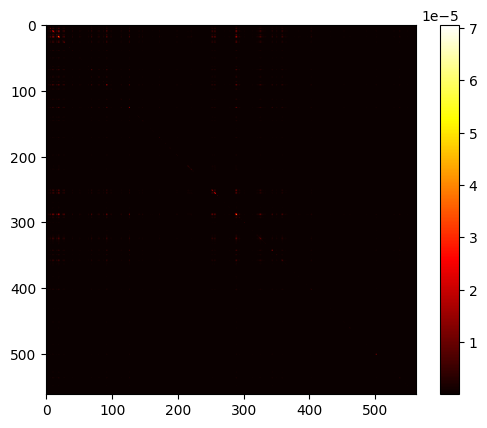

In [161]:
DcovMat = np.nan_to_num(DcovMat)
plt.imshow(DcovMat, cmap = 'hot')
plt.colorbar()
plt.show()

In [129]:

X = NetworkDf.values.astype('float64')
myScaler = preprocessing.StandardScaler()
X = myScaler.fit_transform(X)
emp_cov = covariance.empirical_covariance(X)
shrunk_cov = covariance.shrunk_covariance(emp_cov, shrinkage=0.82) # Set shrinkage closer to 1 for poorly-conditioned data

alphaRange = 10.0 ** np.arange(-8,0) # 1e-7 to 1e-1 by order of magnitude
for alpha in alphaRange:
    try: 
        graphCov = covariance.graphical_lasso(shrunk_cov, alpha)
        print("Calculated graph-lasso covariance matrix for alpha=%s"%alpha)
    except FloatingPointError:
        print("Failed at alpha=%s"%alpha)


c:\Users\bobby\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.918994305300409e-05, tolerance: 6.801943154385435e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Calculated graph-lasso covariance matrix for alpha=1e-08
Calculated graph-lasso covariance matrix for alpha=1e-07
Calculated graph-lasso covariance matrix for alpha=1e-06
Calculated graph-lasso covariance matrix for alpha=1e-05
Calculated graph-lasso covariance matrix for alpha=0.0001
Calculated graph-lasso covariance matrix for alpha=0.001
Calculated graph-lasso covariance matrix for alpha=0.01
Calculated graph-lasso covariance matrix for alpha=0.1


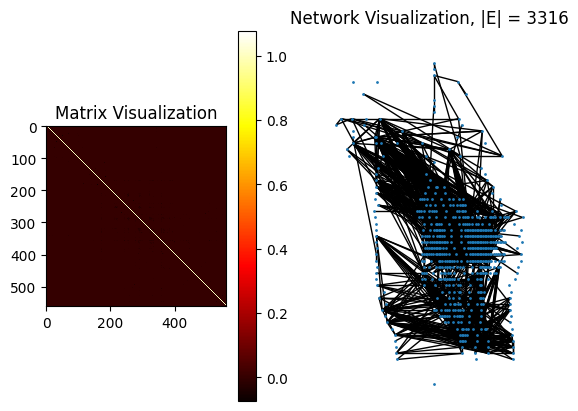

In [198]:
graphCov = covariance.graphical_lasso(shrunk_cov, 0.05)

#Covariance Plotting
fig, axs = plt.subplots(1,2)
im1 = axs[0].imshow(graphCov[1], cmap = 'hot', interpolation='nearest')
fig.colorbar(im1)
axs[0].set_title("Matrix Visualization")

#Network Visualization
Cells = pd.read_csv('../NetworkDataSets/Cells2015_2020.csv').drop('Unnamed: 0', axis = 1)
def check_touching_cells(cell, cell_list):
    cell_list = cell_list[cell_list['id'] != cell[6]]
    edges = []
    for index, cell2 in cell_list.iterrows():
        if cell2[1] == cell[1] and cell2[0] + cell2[2] == cell[0]: 
                #If they are in the same row, and touch horisontally
                edges.append([cell[6], cell2[6]])
        elif cell2[1] + cell2[3] == cell[1]:
            if cell2[0] >= cell[0] and cell2[0] <= cell[0] + cell[2]:
                #If cell2 touches cell from the bottom and cell2 starts in the middle of cell
                edges.append([cell[6], cell2[6]])
            elif cell2[0] + cell2[2] >= cell[0] and cell2[0] + cell2[2]  <= cell[0] + cell[2]:
                edges.append([cell[6], cell2[6]])
            elif cell2[0] <= cell[0] and cell2[0] <= cell[0] + cell[2] and cell2[0] + cell2[2] >= cell[0] and cell2[0] + cell2[2] >= cell[0] + cell[2]:
                edges.append([cell[6], cell2[6]])
    
    return edges
pos = {}
for index, cell in Cells.iterrows():
    pos[cell[6]] = ((2*cell[0] + cell[2])/2, (cell[1]))
    
edges = []
for i in range(ProportionDf.shape[1]):
    for j in range(ProportionDf.shape[1]):
        if abs(graphCov[1][i,j]) > 0 and i < j:
            edges.append([i,j])
        else:
            pass
plt.sca(axs[1])
g = nx.Graph()
g.add_nodes_from([i for i in range(ProportionDf.shape[1])])
g.add_edges_from(edges)

nx.draw(g, pos = pos, node_size = 1)
axs[1].set_title(f"Network Visualization, |E| = {len(edges)}")
plt.show()

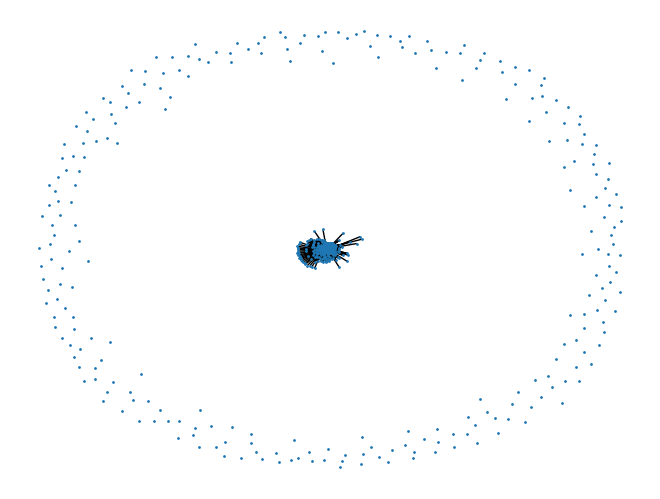

In [162]:

edges = []
for i in range(ProportionDf.shape[1]):
    for j in range(ProportionDf.shape[1]):
        if abs(DcovMat[i,j]) > 10**-7 and i != j:
            edges.append([i,j])
        else:
            pass

g = nx.Graph()
g.add_nodes_from([i for i in range(ProportionDf.shape[1])])
g.add_edges_from(edges)

nx.draw(g, node_size = 1)